<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/simple_cnn_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


In [5]:
# mini-batch size
nbatch = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=nbatch,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=nbatch,
                                         shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

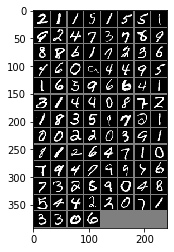

    2     1     1     5     1     5     5     1     9     2     4     7     3     7     8     9     8     8     6     1     7     2     3     6     4     6     0     9     4     4     9     5     1     6     3     9     6     6     4     1     3     1     4     4     0     8     7     2     1     8     3     5     9     7     2     1     0     0     2     2     0     3     9     1     8     1     2     6     4     7     1     0     7     9     4     7     9     9     4     6     7     3     2     5     9     0     4     8     5     4     4     2     2     0     7     1     3     3     0     6


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(nbatch)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

net = Net()
print(net)

# To GPU
net = try_gpu(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
nepochs = 2
for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = try_gpu(inputs)
        labels = try_gpu(labels)

#        print('inputs:')
#        print(inputs)
#        print('labels:')
#        print(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#        print('outputs')
#        print(outputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.110
[1,   200] loss: 0.072
[1,   300] loss: 0.041
[1,   400] loss: 0.034
[1,   500] loss: 0.030
[1,   600] loss: 0.027
[2,   100] loss: 0.025
[2,   200] loss: 0.024
[2,   300] loss: 0.021
[2,   400] loss: 0.021
[2,   500] loss: 0.019
[2,   600] loss: 0.018
Finished Training


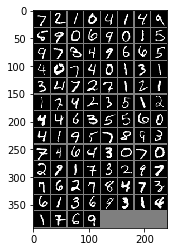

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1     3     4     7     2     7     1     2     1     1     7     4     2     3     5     1     2     4     4     6     3     5     5     6     0     4     1     9     5     7     8     9     3     7     4     6     4     3     0     7     0     2     9     1     7     3     2     9     7     7     6     2     7     8     4     7     3     6     1     3     6     9     3     1     4     1     7     6     9
Predicted:        5     1     2     6     3     7     8     9     9     4     4     6     8     7     6     1     3     6     3     8     7     1     0     6     2     5     4     4     9     0     2     0     4     8     9     8     8     6     0     2     9     3     6     6     3     2     8     0     9     6     9     3     2     0     4     5     7     8     3     4     0     7 

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(nbatch)))

_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(nbatch)))

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = try_gpu(images)
        labels = try_gpu(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = try_gpu(images)
        labels = try_gpu(labels)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(nbatch):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 97 %
Accuracy of     1 : 95 %
Accuracy of     2 : 88 %
Accuracy of     3 : 85 %
Accuracy of     4 : 89 %
Accuracy of     5 : 82 %
Accuracy of     6 : 94 %
Accuracy of     7 : 88 %
Accuracy of     8 : 86 %
Accuracy of     9 : 87 %
